# Machine learning for chemistry 2

The purpose of this exercise is to learn to use neural networks for regression.

The exercise is about investigating the standard architecture for neural networks (multilayer perceptrons or rather fully-connected neural networks) and applied to a regression task (the prediction of a material property of inorganic compounds). Neural networks for classification are briefly explained as well, while more details on this topic can be found in the tutorial on convolutional neural networks.

This exercise is based on NOMAD multilayer perceptron tutorial [1]. The data is from [2].

[1] NOMAD, AI Toolkit tutorials, https://nomad-lab.eu/prod/analytics/public/user/c9452885-da27-40ac-a72d-65f32f4cb157/notebooks/tutorials/nn_regression.ipynb#_ (accessed 24.11.2022. Link is no longer accessable, but one could try https://gitlab.mpcdf.mpg.de/nomad-lab/ai-toolkit/tutorial-nn-regression , updated Nov 27, 2024.)

[2] D. Jha, L. Ward, A. Paul, W.-k. Liao, A. Choudhary, C. Wolverton and A. Agrawal. Elemnet: Deep learning the chemistry of materials from only elemental composition. Scientific reports 8, 1 (2018)

The goal is then to predict the volume per atom for inorganic solids from the open quantum materials database (OQMD). Only information on the chemical composition is used  (in particular, no structural information). The results are analyzed using typical performance measures such as mean absolute error, mean squared error, root mean square error, and the Pearson correlation coefficient. Visualization techniques and advanced optimization methods are discussed at the end.

## 1. Load packages

Let's start by importing the relevant packages.

In [1]:
!pip install -U --pre tensorflow=="2.*"
!pip install keras
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install mendeleev
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 10.4 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.2 MB/s eta 0:00:0031m11.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 11.1 MB/s eta 0:00:0031m11.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 11.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:0031m11.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 11.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.0 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 11.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 11.2 MB/s eta 0:00:00 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

The following packages are required for this tutorial:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow as backend for keras (see below)
import tensorflow as tf

# Keras for neural networks
from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model

# other packages
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
from collections import Counter

# sklearn
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# pandas
import pandas as pd

# json
import json

# mendeleev
from mendeleev import element as Element

2024-11-27 21:28:39.031353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 21:28:39.035362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 21:28:39.046553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732739319.065129  265589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732739319.070412  265589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 21:28:39.091181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 2. Neural network regression example - "ElemNet"

In the following, we will consider a specific application of multilayer perceptrons. The idea of this section is that you first read through/run all the following texts/cells and then return to them later (in particular, changing the neural-network parameter settings) when answering the questions in section 2.5.

"ElemNet" is a deep-learning approach to predict material properties using information on the chemical composition only. In particular, no structural information is used, i.e., the atomic positions and the corresponding symmetries are not considered (which is frequently employed in other machine and deep learning projects in materials science). More information on ElemNet can be found in the following references:

* Dipendra Jha, Logan Ward, Arindam Paul, Wei-keng Liao, Alok Choudhary, Chris Wolverton, and Ankit Agrawal, “ElemNet: Deep Learning the Chemistry of Materials From Only Elemental Composition,” Scientific Reports, 8, Article number: 17593 (2018) [DOI:10.1038/s41598-018-35934-y] 
* Dipendra Jha, Kamal Choudhary, Francesca Tavazza, Wei-keng Liao, Alok Choudhary, Carelyn Campbell, Ankit Agrawal, "Enhancing materials property prediction by leveraging computational and experimental data using deep transfer learning," Nature Communications, 10, Article number: 5316 (2019) [DOI: https:10.1038/s41467-019-13297-w] 
* https://github.com/NU-CUCIS/ElemNet

The deep-learning model behind "ElemNet" is essentially a multilayer perceptron with the input vector being chosen in a very specific way: 
Each compound is represented by a feature vector $\mathbf{f}$ of fixed length, whose components correspond to the elements of the periodic table. They are sorted according to the atomic number Z in ascending order (i.e., the first component of $\mathbf{f}$ corresponds to hydrogen, the second to Helium etc.).
For instance, given a binary compound $\text{A}_x \text{B}_y$ with $x+y=1$, all entries of $\mathbf{f}$ are zero except those corresponding to element A and B. For these entries, the relative stoichiometric attributes x and y are assigned. In case of NaCl (rock salt), the representation would be 

$\begin{equation*}
\mathbf{f} = (0.0,\ 0.0,\ ...,\ 0.0,\ 0.5,\ 0.0,\ ..., 0.0,\ 0.5,\ 0.0,\ ...),
\end{equation*}$

where only the two entries corresponding to Na and Cl are assigned non-zero values (0.5 in this case). 

### 2.1 The task and dataset creation

Given only the chemical composition of an inorganic compound, the goal is to predict the volume per atom, which is the total volume of the unit cell divided by the number of atoms in the unit cell. This property provides an average characterization of the atomic arrangement and therefore becomes interesting in context of crystal-structure prediction (we refer the interested reader to [this paper](https://www.nature.com/articles/s41578-019-0101-8) for a review on this topic). Note, however, that this quantity is only an average characterization of the unit cell geometry and thus further properties have to be known (for instance total volume, space group) to get a geometrical understanding of the crystal that is sufficient to actually predict the atomic arrangement.

This target property has been predicted using several other machine learning algorithms before (specifically, decision trees) in the following reference:

L. Ward, A. Agrawal, A. Choudhary and C. Wolverton. A general-purpose machine learning framework for predicting
properties of inorganic materials. npj Computational Materials 2, 16028 (2016).

While in this reference (and also the "ElemNet"-related works listed above) energetic targets (such as formation energy) were the main focus, we will use "ElemNet" to predict the volume per atom. 

For this purpose, we need to create the dataset in the first step. Information on stoichiometry and volume per atom can be extracted from the dataset published in Ward et al. (2016) (which is based on the open quantum materials database (OQMD), see  the [original paper](https://link.springer.com/article/10.1007/s11837-013-0755-4) and the [documentation](http://oqmd.org/)). This step has already been done and we provide the prepared dataset. We also eliminated some data points with very large volumes (>100$Å^3$ per atom). Furthermore, we computed the input representation required by "ElemNet". This is a common situation: the data is available in some format, but additional preprocessing (data cleaning, feature engineering) is necessary.

Let us first load the dataset containing information on the chemical composition (in particular the stoichiometry), for which we use pandas (https://pandas.pydata.org/, a python library providing convenient ways to store, load and process data):

In [2]:
def zenodo_data_loader():
  !wget https://zenodo.org/record/7129315/files/OQMD_Ward_et_al_2016_df.pkl
  !wget https://zenodo.org/record/7129315/files/X_ElemNet_NOMAD.npy

In [3]:
def data_loader():

  zenodo_data_loader()

  df = pd.read_pickle('OQMD_Ward_et_al_2016_df.pkl')

  X_ElemNet = np.load('X_ElemNet_NOMAD.npy', allow_pickle=True)

  return X_ElemNet, df

X_ElemNet, df = data_loader()

--2024-11-27 21:28:55--  https://zenodo.org/record/7129315/files/OQMD_Ward_et_al_2016_df.pkl
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7129315/files/OQMD_Ward_et_al_2016_df.pkl [following]
--2024-11-27 21:28:55--  https://zenodo.org/records/7129315/files/OQMD_Ward_et_al_2016_df.pkl
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 17335181 (17M) [application/octet-stream]
Saving to: ‘OQMD_Ward_et_al_2016_df.pkl’

OQMD_Ward_et_al_201 100%[===================>]  16.53M  10.1MB/s    in 1.6s    

2024-11-27 21:28:57 (10.1 MB/s) - ‘OQMD_Ward_et_al_2016_df.pkl’ saved [17335181/17335181]

--2024-11-27 21:28:57--  https://zenodo.org/record/7129315/files/X_ElemNet_NOMAD.npy
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.4

In [4]:
df

,vol_per_atom,composition,number_of_elements,stoichiometry_dicts
0,17.8351,Li1,1,{'Li': 1}
1,22.9639,Mg1,1,{'Mg': 1}
2,41.4146,Kr1,1,{'Kr': 1}
3,32.9826,Na1,1,{'Na': 1}
4,15.2088,Pd1,1,{'Pd': 1}
...,...,...,...,...
347222,12.8367,O3Pt1,2,"{'O': 3, 'Pt': 1}"
347223,13.5009,O3Sn1,2,"{'O': 3, 'Sn': 1}"
347224,10.3609,Co1O3,2,"{'Co': 1, 'O': 3}"
347225,10.4791,Hf2Li1O6,3,"{'Hf': 2, 'Li': 1, 'O': 6}"


In [5]:
X_ElemNet

array([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.11111111, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [6]:
y_vol_per_atom = df['vol_per_atom'].values
number_of_elements = df['number_of_elements'].values
stoichiometry_dicts = df['stoichiometry_dicts']

elements_of_interest = []
for stoichiometry_dict in stoichiometry_dicts:
    for species in stoichiometry_dict:
        elements_of_interest.append(species)

Now we can have a look at the statistics of this dataset, in particular the distribution of the target property:

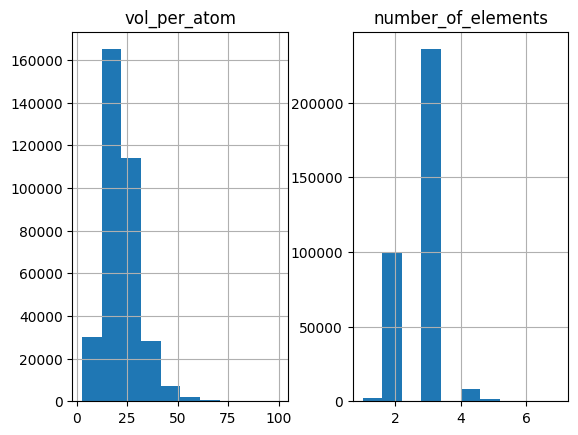


Statistics of the target property:

count    347227.000000
mean         22.157036
std           8.613623
min           2.723960
25%          16.116350
50%          20.881500
75%          26.504150
max          99.884500
Name: vol_per_atom, dtype: float64


In [7]:
df.hist()
plt.show()
print('\nStatistics of the target property:\n')
print(df['vol_per_atom'].describe())

We already see at this point that most of the compounds have three chemical species. To provide more insight, the code below will print out the total number of data points, what kind of materials are actually appearing (specifically the amount of species being present) and furthermore, which elements of the periodic table occur and how often (which is visualized in a bar plot): 

Total number of datapoints: 347227

Compounds with 1 element(s) appear 2472 times in the dataset
Compounds with 2 element(s) appear 99411 times in the dataset
Compounds with 3 element(s) appear 235658 times in the dataset
Compounds with 4 element(s) appear 8248 times in the dataset
Compounds with 5 element(s) appear 1320 times in the dataset
Compounds with 6 element(s) appear 112 times in the dataset
Compounds with 7 element(s) appear 6 times in the dataset

The following elements (in total 89) appear in the dataset:

 ['H' 'He' 'Li' 'Be' 'B' 'C' 'N' 'O' 'F' 'Ne' 'Na' 'Mg' 'Al' 'Si' 'P' 'S'
 'Cl' 'Ar' 'K' 'Ca' 'Sc' 'Ti' 'V' 'Cr' 'Mn' 'Fe' 'Co' 'Ni' 'Cu' 'Zn' 'Ga'
 'Ge' 'As' 'Se' 'Br' 'Kr' 'Rb' 'Sr' 'Y' 'Zr' 'Nb' 'Mo' 'Tc' 'Ru' 'Rh' 'Pd'
 'Ag' 'Cd' 'In' 'Sn' 'Sb' 'Te' 'I' 'Xe' 'Cs' 'Ba' 'La' 'Ce' 'Pr' 'Nd' 'Pm'
 'Sm' 'Eu' 'Gd' 'Tb' 'Dy' 'Ho' 'Er' 'Tm' 'Yb' 'Lu' 'Hf' 'Ta' 'W' 'Re' 'Os'
 'Ir' 'Pt' 'Au' 'Hg' 'Tl' 'Pb' 'Bi' 'Ac' 'Th' 'Pa' 'U' 'Np' 'Pu']


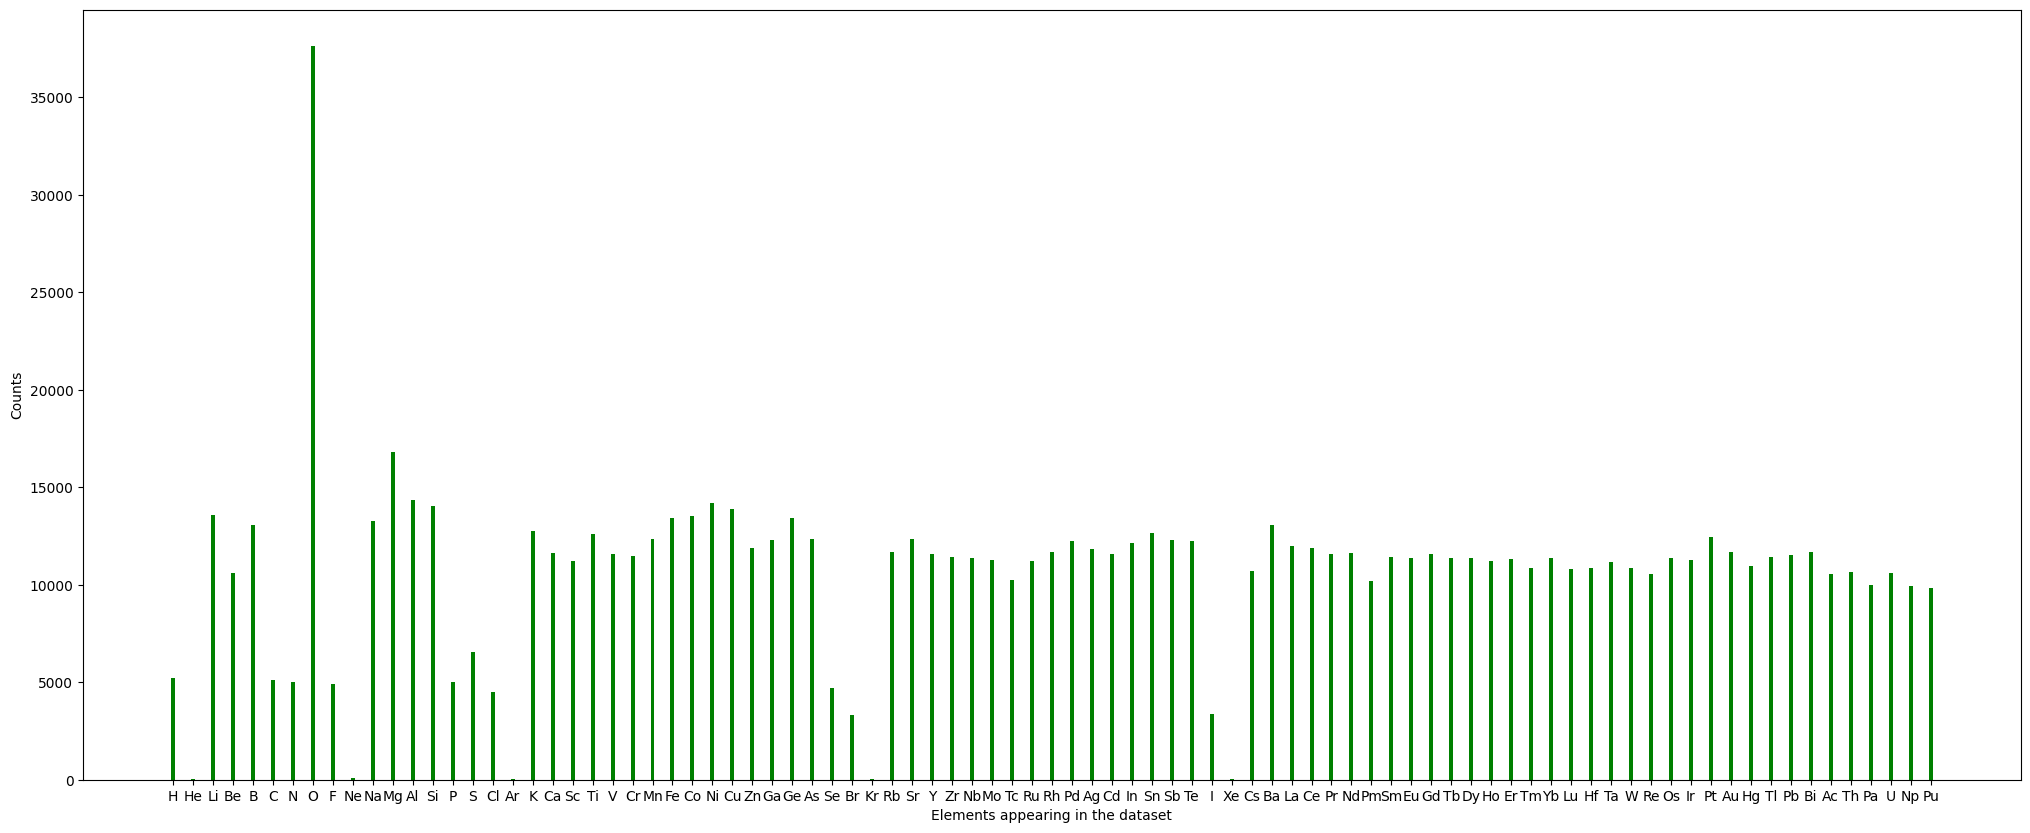

In [8]:
print("Total number of datapoints: {}\n".format(len(y_vol_per_atom)))

from collections import Counter
dict_elements = dict(Counter(number_of_elements))
for key in dict_elements:
    print("Compounds with {} element(s) appear {} times in the dataset".format(key, dict_elements[key]))
    
# Order elements according to Z
elements_of_interest_unique = np.array(list(set(elements_of_interest)), dtype=object)
Z_values = []
for element in elements_of_interest_unique:
    Z_values.append(Element(element).atomic_number)
sorted_indices = np.argsort(Z_values)
elements_of_interest_sorted = elements_of_interest_unique[sorted_indices]
print("\nThe following elements (in total {}) appear in the dataset:\n\n {}".format(len(elements_of_interest_sorted), elements_of_interest_sorted))

elements_appearance = dict(Counter(elements_of_interest))
elements_appearance_sorted = [elements_appearance[_] for _ in elements_of_interest_sorted]
fig = plt.figure(figsize=(25,10))
plt.bar(elements_of_interest_sorted, elements_appearance_sorted, width=.2, color='g')
plt.xlabel('Elements appearing in the dataset')
plt.ylabel('Counts')
plt.show()

From the bar plot, we see that most of the materials contain oxygen. This reflects the bias of researchers towards investigating specific systems (i.e., those that are well-known or interesting for a specific application).

Note that elements that do not appear in the dataset are not included in the feature vector (since otherwise some input neurons would be zero for every data point, thus making them useless and even worse, they might disturb the learning process). 

Now the dataset is ready for training. For completeness, let us print the shapes of input features and targets:

In [9]:
print("Input shape = {}, target shape = {}".format(X_ElemNet.shape, y_vol_per_atom.shape))

Input shape = (347227, 89), target shape = (347227,)


### 2.2 Dataset training / test split

The first step is to split the data into training and test set, the latter not being touched during optimization and only at the end for the final model test. Note that it is essential to report split ratio and random state to enable reproducibility:

In [10]:
# Very important for reproducibility!
RANDOM_STATE = 42
split_ratio = 0.2

# 80 /20 Split for creating training and test set 
X, X_test, y, y_test = train_test_split(X_ElemNet, y_vol_per_atom,
                                        test_size=split_ratio, random_state=RANDOM_STATE)

Another typical preprocessing step is to scale the input features (for instance using mean and standard deviation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 
This can improve model performance, while for the moment it is not used - still, the interested reader can experiment with this preprocessing procedure by uncommenting the following code block:

In [ ]:
"""
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
"""

Now we perform an additional 80/20 split and use the 80% portion for training the model and the 20% portion for validation:

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=split_ratio, random_state=RANDOM_STATE)

If we are not satisfied with the validation performance, we can take a step back, change the hyperparameters (such as the number of layers or number of neurons in each layer), and restart the training process. This way, we can optimize the generalization ability of the model, before the final evaluation on the test set. Ideally, one should also consider different splits (for instance via *cross-validation*, see capter 7.10 of this [book](https://link.springer.com/book/10.1007/978-0-387-84858-7)), which would be too time-consuming for  this tutorial. The code provided in this tutorial is only for hand-tuning the hyperparameters while references on more advanced methods can be found in section 3 (e.g., Bayesian optimization). 

### 2.3 Model definition and training phase

We use the python library Keras to create the multilayer perceptron architecture (the online documentation is an excellent resource for more details - please refer to the side remark at the beginning of the tutorial for the URLs). The function defined below will generate a model object from a dictionary "params", which will be defined later and contains specifications about the model architecture:

In [12]:
n_feat = X_train.shape[1]

def create_model(params):
    x_input = Input(shape=(n_feat,), name="x_input")
    dropout_values = params["dropout"]

    for i, n_nodes in enumerate(params["arch"]):
        if i == 0:
            x = Dense(n_nodes, activation="relu")(x_input)
        else:
            x = Dense(n_nodes, activation="relu")(x)
        dropout = dropout_values[i]
        x = Dropout(dropout)(x)

    output = Dense(1)(x)

    model = Model(x_input, output)
    model.compile(optimizer="adam", loss=["mse"])

    return model

In this function, a particular loss function is chosen (see "model.compile(...)"), the mean squared error (MSE):

$\begin{equation*}
MSE = \sum_{i=1}^m (y_i - \widehat{y}_i)^2,
\end{equation*}$

where m is the number of training examples, $y_i$ denotes the $i$th ground truth and $\widehat{y}_i$ the $i$th predicted target.

Several hyperparameters can be optimized, most notably the number of layers, the number of neurons in each layer, and regularization parameters. Let us discuss the choice of regularization in more detail in the following:

To have a valuable machine learning model, it is of paramount importance to make sure that the model generalizes well to unseen samples.

Goodfellow *et.al.* (cf. chapter [5.2.2](https://www.deeplearningbook.org/contents/ml.html)) define regularization as *any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error.* In practice, additional terms are added to the training optimization objective to prevent overfitting or help the optimization.

There are numerous ways to regularize a neural network; we refer the interested reader to Chapter [7](https://www.deeplearningbook.org/contents/regularization.html).

Here, we use **dropout layers** to regularize our neural network. To explain in a few word what dropout is, we report below the abstract from the article that introduced dropout (Srivastava *et al.*, J. Mach. Learn. Res. 15 1929 (2014)):

*Deep neural nets with a large number of parameters are very powerful machine learning systems. However, overfitting is a serious problem in such networks. Large networks are also slow to use, making it difficult to deal with overfitting by combining the predictions of many different large neural nets at test time. Dropout is a technique for addressing this problem.*

*The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights.*

*This significantly reduces overfitting and gives major improvements over other regularization methods. We show that dropout improves the performance of neural networks on supervised learning tasks in vision, speech recognition, document classification and computational biology, obtaining state-of-the-art results on many benchmark data sets.*

For the full article "Srivastava et al., Dropout: A Simple Way to Prevent Neural Networks from Overfitting", please visit http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf.


One may also try to change the training time, which is determined by the number of epochs. Specifically, during one epoch, the training set is partitioned into batches - introducing another tunable parameter, the batch size  (cf. chapter [8.1.3](https://www.deeplearningbook.org/) or [this blog](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)) - and after one epoch a full pass through the training set is completed. 

We provide some reasonable choices for hyperparameters below and print a summary of the neural network model:

In [13]:
batch_size = 64
epochs = 30

number_of_neurons_per_layer = [512, 256, 128, 64, 32, 18, 8, 4]
dropout_values = [0.1, 0.05, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0]

params = {
        'arch': number_of_neurons_per_layer,
        'batch_size': batch_size,
        'epochs': epochs,
        'dropout': dropout_values
        }

model = create_model(params)
print(model.summary())

2024-11-27 21:29:49.692230: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 89)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │           594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,427 (864.95 KB)

 Trainable params: 221,427 (864.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Now we fit the model to the training data, while computing the mean squared error on the validation set for each epoch. A pretrained model is provided, while you can also start from a fresh one (just replace "reload=True" with "reload=False"):

In [14]:
reload = True

if reload:
    model = load_model('./model.keras')
    with open('./history.json') as json_file:
        history = json.load(json_file)
else:
    history = model.fit(X_train, y_train,
                        validation_data = (X_val, y_val),
                        epochs=params["epochs"],
                        batch_size=params["batch_size"], verbose=True)
    # save new model
    model.save('./new_model.keras')
    with open('./new_history.json', 'w') as outfile:
        json.dump(history.history, outfile)
    

/home/qliu/Software/anaconda3/envs/test1/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


We can visualize the training and validation accuracy for each epoch:

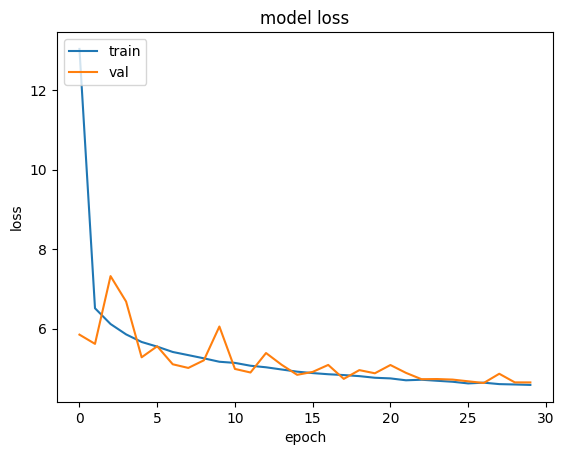

In [15]:
import matplotlib.pyplot as plt

# summarize history for loss: A plot of loss on the training and validation datasets over training epochs.
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In addition, we can compute several performance metrics to evaluate our model:

* Mean absolute error: $\begin{equation*}
MAE = \sum_{i=1}^m |y_i - \widehat{y}_i|,
\end{equation*}$

* Root mean squared error: $\begin{equation*}
RMSE = \sqrt{\sum_{i=1}^m (y_i - \widehat{y}_i)^2},
\end{equation*}$

* Pearson correlation coefficient (0 for no correlation, 1 for positive linear correlation, and -1 for negative linear correlation), see for instance [wikipedia](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).


***Important note:*** We always have to compare these quantities with the statistics of the dataset, i.e., we have to provide at least the range (minimum, maximum) as well as mean and standard deviation.

We compute the above performance metrics for both training and validation set, while also stating the dataset statistics:

In [16]:
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

y_pred_train = model.predict(X_train).flatten()
y_true_train = y_train
mae_train = mean_absolute_error(y_true_train, y_pred_train)
mse_train = rmse(y_pred_train, y_true_train)**2
rmse_train = rmse(y_pred_train, y_true_train)
pearson_train = np.corrcoef(y_pred_train, y_true_train)[0,1]

print("Training: MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | Pearson: {:.3f}".format(mae_train, mse_train,
                                                                                    rmse_train, pearson_train))
dataset = y_train
min_data = min(dataset)
max_data = max(dataset)
mean_data = np.mean(dataset)
sd_data = np.sqrt(np.var(dataset))
print("Dataset: Min: {:.3f} | Max: {:.3f} | Mean: {:.3f} | Std.dev.: {:.3f}".format(min_data, max_data,
                                                                                   mean_data, sd_data))


print('\n')

y_pred_val = model.predict(X_val).flatten()
y_true_val = y_val
mae_val = mean_absolute_error(y_true_val, y_pred_val)
mse_val = rmse(y_pred_val, y_true_val)**2
rmse_val = rmse(y_pred_val, y_true_val)
pearson_val = np.corrcoef(y_pred_val, y_true_val)[0,1]

print("Validation: MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | Pearson: {:.3f}".format(mae_val, mse_val,
                                                                                      rmse_val, pearson_val))

dataset = y_val
min_data = min(dataset)
max_data = max(dataset)
mean_data = np.mean(dataset)
sd_data = np.sqrt(np.var(dataset))
print("Dataset: Min: {:.3f} | Max: {:.3f} | Mean: {:.3f} | Std.dev.: {:.3f}".format(min_data, max_data,
                                                                                   mean_data, sd_data))

6945/6945 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Training: MAE: 1.024 | MSE: 4.148 | RMSE: 2.037 | Pearson: 0.972
Dataset: Min: 2.726 | Max: 98.717 | Mean: 22.149 | Std.dev.: 8.588


1737/1737 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Validation: MAE: 1.079 | MSE: 4.649 | RMSE: 2.156 | Pearson: 0.969
Dataset: Min: 2.724 | Max: 99.106 | Mean: 22.167 | Std.dev.: 8.672


###  2.4 Visualization

Seaborn (https://seaborn.pydata.org/) provides some nice visualization tools and is compatible with the pandas library. For instance, one can visualize the model performance on the validation set by plotting true vs predicted target in a scatter plot, while showing the respective densities as projections:

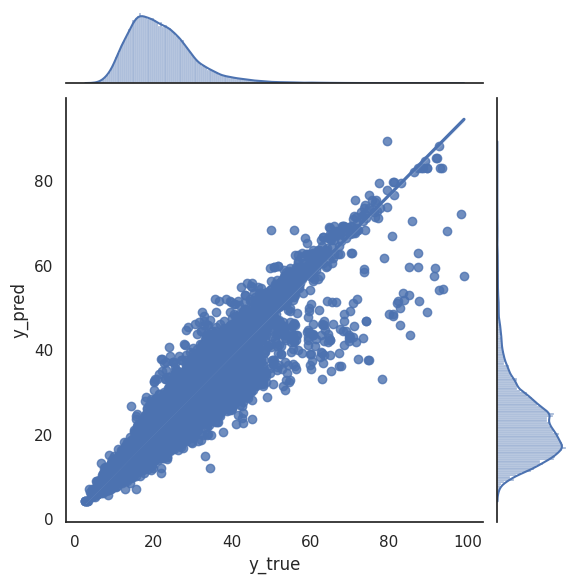

In [24]:
y_true = y_true_val
y_pred = y_pred_val

#Convert validation predictions to pandas dataframe
df = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})


# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df, kind="reg")
plt.show()

### 2.5 Test

Once model optimization is finished, we are ready to investigate model performance on the test set - set the following keyword to True and then run the subsequent cell. Evaluate and interpret your final results. 

In [18]:
investigate_test_set = True

2171/2171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test: MAE: 1.089 | MSE: 4.666 | RMSE: 2.160 | Pearson: 0.968


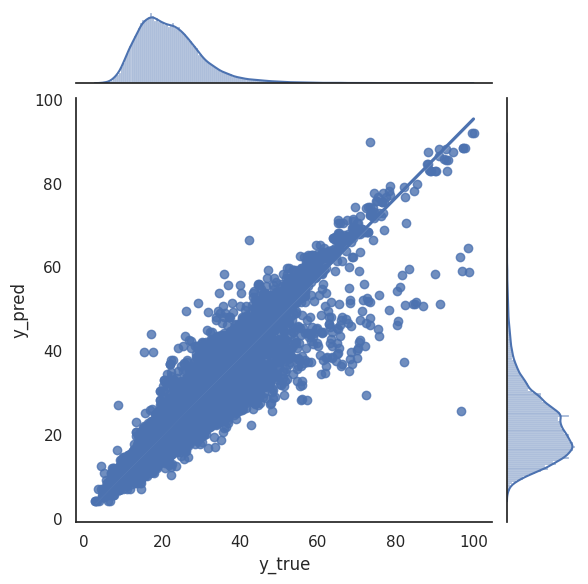

In [25]:
if investigate_test_set:
    y_pred_test = model.predict(X_test).flatten()
    y_true_test = y_test
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mse_test = rmse(y_pred_test, y_true_test)**2
    rmse_test = rmse(y_pred_test, y_true_test)
    pearson_test = np.corrcoef(y_pred_test, y_true_test)[0,1]

    print("Test: MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | Pearson: {:.3f}".format(mae_test, mse_test,
                                                                                          rmse_test, pearson_test))

    
y_true = y_test
y_pred = y_pred_test

#Convert validation predictions to pandas dataframe
df = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})


# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df, kind="reg")
plt.show()